In [1]:
# ============================================
# Block 1 — Setup & Imports (CLEAN)
# ============================================

import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

# --------------------------------------------
# PATH SETUP  (same paths you used before)
# --------------------------------------------
ROOT_DIR = r"C:\Users\anama\Documents\Group_8"
DATASET_DIR = os.path.join(ROOT_DIR, "Dataset", "DERM7PT")

META_CSV = os.path.join(DATASET_DIR, "meta", "meta.csv")
IMAGES_FOLDER = os.path.join(DATASET_DIR, "images")

print("META_CSV:", META_CSV)
print("IMAGES_FOLDER:", IMAGES_FOLDER)

# --------------------------------------------
# Torch device + seeds (for reproducibility)
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Torch version:", torch.__version__)
print("Using device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Seeds set!")


META_CSV: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\meta\meta.csv
IMAGES_FOLDER: C:\Users\anama\Documents\Group_8\Dataset\DERM7PT\images
Torch version: 2.7.1+cu118
Using device: cuda
Seeds set!


In [2]:
# ============================================
# Block 2 — Load & Clean Metadata (CLEAN)
# ============================================

import pandas as pd
import os

# -----------------------------
# Load CSV
# -----------------------------
df = pd.read_csv(META_CSV)
print("Loaded meta.csv — shape:", df.shape)

# -----------------------------
# Drop useless columns
# -----------------------------
df = df.drop(columns=["case_num", "case_id", "notes"], errors="ignore")

# -----------------------------
# Add full image path
# -----------------------------
df["derm_fullpath"] = df["derm"].apply(lambda x: os.path.join(IMAGES_FOLDER, x))

# Validate image paths
df["derm_exists"] = df["derm_fullpath"].apply(os.path.exists)
missing = df[~df["derm_exists"]]

print("Missing images:", len(missing))
if len(missing) > 0:
    display(missing.head())

# -----------------------------
# Show sample for sanity check
# -----------------------------
print("\nCleaned sample rows:")
display(df.head(3)[["diagnosis", "seven_point_score", "derm", "derm_exists"]])

print("\nFinal columns:")
print(df.columns.tolist())


Loaded meta.csv — shape: (1011, 19)
Missing images: 0

Cleaned sample rows:


,diagnosis,seven_point_score,derm,derm_exists
0,basal cell carcinoma,0,NEL/Nel026.jpg,True
1,basal cell carcinoma,1,NEL/Nel028.jpg,True
2,basal cell carcinoma,1,NEL/Nel033.jpg,True



Final columns:
['diagnosis', 'seven_point_score', 'pigment_network', 'streaks', 'pigmentation', 'regression_structures', 'dots_and_globules', 'blue_whitish_veil', 'vascular_structures', 'level_of_diagnostic_difficulty', 'elevation', 'location', 'sex', 'management', 'clinic', 'derm', 'derm_fullpath', 'derm_exists']


In [3]:
# ============================================
# Block 3 — Class Distribution & Label Encoding
# ============================================

from sklearn.preprocessing import LabelEncoder

print("\n==========================")
print("CLASS DISTRIBUTION (RAW)")
print("==========================")

class_counts = df["diagnosis"].value_counts().sort_values(ascending=False)
print(class_counts)

# ------------------------------------------------
# Drop only classes with < 2 samples (e.g. 1 case)
# ------------------------------------------------
rare = class_counts[class_counts < 2]
print("\nClasses with < 2 samples:")
print(rare if len(rare) > 0 else "None")

if len(rare) > 0:
    df = df[~df["diagnosis"].isin(rare.index)].reset_index(drop=True)
    print(f"\nDropped classes: {list(rare.index)}")
else:
    print("\nNo classes dropped.")

print("Rows remaining after drop:", len(df))

# ------------------------------------------------
# Label encode diagnosis → integer label
# ------------------------------------------------
le = LabelEncoder()
df["label"] = le.fit_transform(df["diagnosis"])

print("\nFinal classes (LabelEncoder):")
for i, cls in enumerate(le.classes_):
    print(f"{i:2d} -> {cls}")

NUM_CLASSES = len(le.classes_)
print("\nNumber of classes:", NUM_CLASSES)



CLASS DISTRIBUTION (RAW)
diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
melanoma                          1
Name: count, dtype: int64

Classes with < 2 samples:
diagnosis
melanoma    1
Name: count, dtype: int64

Dropped classes: ['melanoma']
Rows remaining after drop: 1010

Final classes (LabelEncoder):
 0 -> basal cell carcinoma
 1 -> blue nevus
 2 

**Several diagnosis categories contained fewer than two samples. These classes cannot support stratified splitting or model generalization. Following standard recommendations in multiclass classification (e.g., scikit-learn guidelines), we removed classes with fewer than six samples.since we are using stratified splits as train 70% and 30% temp (val+test). so we need minimum six samples(2 each). This preprocessing step ensures stable training, prevents artificially optimistic metrics, and allows consistent comparison across baseline and fusion models.
additionally i added tiny class for melanoma metastasis beacuse i dont want to loose it as its improtant and this is the best possible way to handl medically imbalance dataset
**

In [4]:
# ==========================================================
#  Block 3 Keep all classes with ≥2 samples & encode labels
# ==========================================================
from sklearn.preprocessing import LabelEncoder

# Count samples
class_counts = df["diagnosis"].value_counts()
print("Class counts:\n", class_counts)

# Keep classes with >=2 samples
valid_classes = class_counts[class_counts >= 2].index
df = df[df["diagnosis"].isin(valid_classes)].reset_index(drop=True)

print("\nClasses kept:", list(valid_classes))
print("Rows remaining:", len(df))

# Encode full labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["diagnosis"])
print("\nEncoded classes:", list(le.classes_))


Class counts:
 diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
Name: count, dtype: int64

Classes kept: ['clark nevus', 'melanoma (less than 0.76 mm)', 'reed or spitz nevus', 'melanoma (in situ)', 'melanoma (0.76 to 1.5 mm)', 'seborrheic keratosis', 'basal cell carcinoma', 'dermal nevus', 'vascular lesion', 'blue nevus', 'melanoma (more than 1.5 mm)', 

Because dermatology datasets are naturally imbalanced, and some rare malignant classes (e.g., melanoma metastasis) have very low sample counts, we applied class-weighted loss and controlled stratified splitting to ensure fair learning across all classes.The original “melanoma” class contained only one sample, making it unusable for supervised learning and preventing valid stratified splitting. This class was removed, while all clinically meaningful melanoma subtypes with adequate samples were retained. Additionally, because melanoma metastasis has only four samples, it was handled separately during stratification to ensure it appears in train/validation/test splits without violating minimum-class requirements.

In [6]:
# ============================
# BLOCK 3 — Final Class Filtering
# (Keep all classes ≥ 2 samples, handle metastasis separately)
# ============================

from sklearn.preprocessing import LabelEncoder

# Count occurrences
class_counts = df["diagnosis"].value_counts()
print("Class counts:\n", class_counts, "\n")

# Remove ONLY classes with < 2 samples
valid_classes = class_counts[class_counts >= 2].index.tolist()

df = df[df["diagnosis"].isin(valid_classes)].reset_index(drop=True)

print("Classes kept:", valid_classes)
print("Rows remaining:", len(df))

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["diagnosis"])

print("\nEncoded classes:", list(le.classes_))

# --- Separate metastasis (for custom stratification later) ---
meta_mask = df["diagnosis"] == "melanoma metastasis"

df_main = df[~meta_mask].reset_index(drop=True)    # all normal classes
df_meta = df[meta_mask].reset_index(drop=True)     # 4 metastasis samples

print("\nMetastasis samples:", len(df_meta))


Class counts:
 diagnosis
clark nevus                     399
melanoma (less than 0.76 mm)    102
reed or spitz nevus              79
melanoma (in situ)               64
melanoma (0.76 to 1.5 mm)        53
seborrheic keratosis             45
basal cell carcinoma             42
dermal nevus                     33
vascular lesion                  29
blue nevus                       28
melanoma (more than 1.5 mm)      28
lentigo                          24
dermatofibroma                   20
congenital nevus                 17
melanosis                        16
combined nevus                   13
miscellaneous                     8
recurrent nevus                   6
melanoma metastasis               4
Name: count, dtype: int64 

Classes kept: ['clark nevus', 'melanoma (less than 0.76 mm)', 'reed or spitz nevus', 'melanoma (in situ)', 'melanoma (0.76 to 1.5 mm)', 'seborrheic keratosis', 'basal cell carcinoma', 'dermal nevus', 'vascular lesion', 'blue nevus', 'melanoma (more than 1.5 mm)',

In [8]:
# ============================
# BLOCK 4 — Stratified Split
# (with special handling for melanoma metastasis)
# ============================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# -----------------------------------------
# 1. Separate metastasis class (rare class)
# -----------------------------------------
meta_mask = df["diagnosis"] == "melanoma metastasis"
df_meta = df[meta_mask].copy()      # 4 samples
df_main = df[~meta_mask].copy()     # remaining 1006 samples

print("Metastasis samples:", len(df_meta))

# -----------------------------------------
# 2. Encode labels on the *full* dataset (stable class order)
# -----------------------------------------
le = LabelEncoder()
df["label"] = le.fit_transform(df["diagnosis"])

# Keep encoded labels for both splits
df_main["label"] = le.transform(df_main["diagnosis"])
df_meta["label"] = le.transform(df_meta["diagnosis"])

print("\nEncoded classes:", list(le.classes_))

# -----------------------------------------
# 3. Stratified train/test split on main data
# -----------------------------------------
train_main, temp_main = train_test_split(
    df_main,
    test_size=0.30,
    stratify=df_main["label"],
    random_state=42
)

# -----------------------------------------
# 4. Split temp_main into val/test (stratified)
# -----------------------------------------
val_main, test_main = train_test_split(
    temp_main,
    test_size=0.50,
    stratify=temp_main["label"],
    random_state=42
)

# -----------------------------------------
# 5. Manually distribute metastasis samples (4 total)
# Train: 2, Val: 1, Test: 1
# -----------------------------------------
df_meta_shuffled = df_meta.sample(frac=1, random_state=42).reset_index(drop=True)

train_meta = df_meta_shuffled.iloc[:2]
val_meta   = df_meta_shuffled.iloc[2:3]
test_meta  = df_meta_shuffled.iloc[3:4]

# -----------------------------------------
# 6. Final splits = main split + metastasis
# -----------------------------------------
train_df = pd.concat([train_main, train_meta]).reset_index(drop=True)
val_df   = pd.concat([val_main,   val_meta]).reset_index(drop=True)
test_df  = pd.concat([test_main,  test_meta]).reset_index(drop=True)

print("\n======== FINAL SPLIT SIZES ========")
print("Train:", len(train_df))
print("Val:  ", len(val_df))
print("Test: ", len(test_df))

print("\nMetastasis distribution:")
print("Train:", sum(train_df["diagnosis"] == "melanoma metastasis"))
print("Val:  ", sum(val_df["diagnosis"] == "melanoma metastasis"))
print("Test: ", sum(test_df["diagnosis"] == "melanoma metastasis"))




Metastasis samples: 4

Encoded classes: ['basal cell carcinoma', 'blue nevus', 'clark nevus', 'combined nevus', 'congenital nevus', 'dermal nevus', 'dermatofibroma', 'lentigo', 'melanoma (0.76 to 1.5 mm)', 'melanoma (in situ)', 'melanoma (less than 0.76 mm)', 'melanoma (more than 1.5 mm)', 'melanoma metastasis', 'melanosis', 'miscellaneous', 'recurrent nevus', 'reed or spitz nevus', 'seborrheic keratosis', 'vascular lesion']

======== FINAL SPLIT SIZES ========
Train: 706
Val:   152
Test:  152

Metastasis distribution:
Train: 2
Val:   1
Test:  1


In [9]:
# ============================
# BLOCK 5 — Class Weights
# ============================

import pandas as pd


# Count classes in TRAIN ONLY (correct way)
train_counts = train_df["label"].value_counts().sort_index()

num_classes = len(train_counts)
total_samples = train_counts.sum()

# Balanced weight formula:
#   weight = total_samples / (num_classes * samples_in_class)
weights = total_samples / (num_classes * train_counts)

# Create DataFrame for clarity
class_weights_df = pd.DataFrame({
    "class_name": le.classes_,
    "train_count": train_counts.values,
    "weight": weights.values
})

print("Class weight table:\n")
print(class_weights_df)



Class weight table:

                      class_name  train_count     weight
0           basal cell carcinoma           29   1.281307
1                     blue nevus           20   1.857895
2                    clark nevus          279   0.133182
3                 combined nevus            9   4.128655
4               congenital nevus           12   3.096491
5                   dermal nevus           23   1.615561
6                 dermatofibroma           14   2.654135
7                        lentigo           17   2.185759
8      melanoma (0.76 to 1.5 mm)           37   1.004267
9             melanoma (in situ)           45   0.825731
10  melanoma (less than 0.76 mm)           71   0.523351
11   melanoma (more than 1.5 mm)           20   1.857895
12           melanoma metastasis            2  18.578947
13                     melanosis           11   3.377990
14                 miscellaneous            6   6.192982
15               recurrent nevus            4   9.289474
16        

In [10]:
# ============================
# BLOCK 6 — Balanced Batch Sampler
# ============================

from torch.utils.data import Sampler
import numpy as np

class BalancedBatchSampler(Sampler):
    """
    Ensures each batch contains balanced samples per class.
    Works well for highly imbalanced datasets.
    """

    def __init__(self, labels, batch_size=32):
        self.labels = np.array(labels)
        self.batch_size = batch_size

        # unique classes
        self.classes = np.unique(self.labels)
        self.num_classes = len(self.classes)

        # samples per class in each batch
        self.samples_per_class = max(1, batch_size // self.num_classes)

        # store indices for each class
        self.class_indices = {c: np.where(self.labels == c)[0] for c in self.classes}

        # shuffle each class initially
        for c in self.classes:
            np.random.shuffle(self.class_indices[c])

        # maintain pointer for each class
        self.ptr = {c: 0 for c in self.classes}

    def __iter__(self):
        batch = []

        while True:
            for c in self.classes:
                idxs = self.class_indices[c]
                p = self.ptr[c]

                # reset + reshuffle when reaching end
                if p + self.samples_per_class >= len(idxs):
                    np.random.shuffle(idxs)
                    p = 0

                # pick samples for this class
                batch.extend(idxs[p : p + self.samples_per_class])
                self.ptr[c] = p + self.samples_per_class

                # yield full batch
                if len(batch) >= self.batch_size:
                    yield batch[:self.batch_size]
                    batch = []

    def __len__(self):
        return len(self.labels) // self.batch_size


In [11]:
# ============================
# BLOCK 7 — PyTorch Dataset + Transforms
# ============================

from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

# ----------------------------
# Image transforms
# ----------------------------
# Light but sensible augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# No augmentation for val/test
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class DermDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row["derm_fullpath"]
        label = row["label"]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# ----------------------------
# Create dataset objects
# ----------------------------
train_dataset = DermDataset(train_df, transform=train_transform)
val_dataset   = DermDataset(val_df,   transform=test_transform)
test_dataset  = DermDataset(test_df,  transform=test_transform)

print("Datasets created successfully!")
print("Train:", len(train_dataset))
print("Val:  ", len(val_dataset))
print("Test: ", len(test_dataset))


Datasets created successfully!
Train: 706
Val:   152
Test:  152


In [24]:
# ============================
# BLOCK 8 — Weighted Sampler DataLoaders (Corrected)
# ============================
from torch.utils.data import DataLoader, WeightedRandomSampler

# Count samples per class
class_counts = train_df["label"].value_counts().sort_index()

# Compute weights: inverse frequency
class_weights = 1.0 / class_counts

# Assign each sample its weight
sample_weights = train_df["label"].map(class_weights).values
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

print("✔ Weighted sampler train loader ready!")
print("Samples per epoch:", len(train_loader))



✔ Weighted sampler train loader ready!
Samples per epoch: 23


In [13]:
# ============================
# BLOCK 9 — MixUp Augmentation
# ============================

import torch
import numpy as np

# Turn MixUp ON or OFF
USE_MIXUP = True
ALPHA = 0.4   # standard MixUp strength for medical datasets


def mixup_data(x, y, alpha=ALPHA):
    """
    Performs MixUp augmentation.
    x: images batch
    y: labels batch (integer encoded)
    """
    if alpha <= 0:
        return x, y, y, 1

    lam = np.random.beta(alpha, alpha)

    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    # Mix the images
    mixed_x = lam * x + (1 - lam) * x[index]

    # Original labels
    y_a = y
    # Shuffled labels
    y_b = y[index]

    return mixed_x, y_a, y_b, lam


print("MixUp ready! (USE_MIXUP =", USE_MIXUP, ")")


MixUp ready! (USE_MIXUP = True )


In [14]:
# ============================
# BLOCK 10 — Weighted Focal Loss
# ============================

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------------------------
# Convert ONLY the weight column to tensor
# (DataFrame is preserved completely)
# -----------------------------------------
class_weights_tensor = torch.tensor(
    class_weights_df["weight"].values,   # keep DF, convert only this column
    dtype=torch.float32
)

# Move weights to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = class_weights_tensor.to(device)

print("Using device:", device)
print("Class weights loaded (DF → Tensor only for loss).")


# -----------------------------------------
# Weighted Focal Loss (multi-class)
# -----------------------------------------
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha    # tensor of size [num_classes]
        self.gamma = gamma

    def forward(self, logits, targets):
        # Cross entropy with class weights
        ce_loss = F.cross_entropy(
            logits,
            targets,
            weight=self.alpha,     # tensor weights
            reduction='none'
        )

        pt = torch.exp(-ce_loss)     # predicted prob of correct class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        return focal_loss.mean()


# Instantiate loss function
criterion = WeightedFocalLoss(
    alpha=class_weights_tensor,
    gamma=2.0
)

print("Weighted Focal Loss ready!")


Using device: cuda
Class weights loaded (DF → Tensor only for loss).
Weighted Focal Loss ready!


In [15]:
# ============================
# BLOCK 11 — Image Augmentation (A, B, C)
# ============================

from torchvision import transforms
import random
from PIL import Image
import numpy as np

# -------------------------------------------------
# SELECT AUGMENTATION MODE HERE:
#    "A" → Light (medical-safe)
#    "B" → Moderate
#    "C" → Strong (research experiment mode)
# -------------------------------------------------
AUG_MODE = "A"   # <-- change to "B" or "C" when testing

print(f"\nUsing Augmentation Mode: {AUG_MODE}")


# =================================================
# MODE A — Light Augmentation (recommended)
# =================================================
transform_A = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])


# =================================================
# MODE B — Moderate Augmentation
# (still medically safe)
# =================================================
transform_B = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.15,
        hue=0.05
    ),
    transforms.ToTensor(),
])


# =================================================
# MODE C — Strong Augmentation
# For research experiments ONLY
# Useful to fight overfitting on small datasets
# =================================================
transform_C = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomVerticalFlip(p=0.7),
    transforms.RandomRotation(40),
    transforms.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.20,
        hue=0.08
    ),
    transforms.ToTensor(),
])


# =================================================
# TEST/VAL transforms (NO augmentation!)
# =================================================
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# =================================================
# SELECT FINAL TRAIN TRANSFORM
# =================================================
if AUG_MODE == "A":
    train_transform = transform_A
elif AUG_MODE == "B":
    train_transform = transform_B
elif AUG_MODE == "C":
    train_transform = transform_C
else:
    raise ValueError("AUG_MODE must be 'A', 'B', or 'C'")

print("Augmentations loaded successfully!")



Using Augmentation Mode: A
Augmentations loaded successfully!


In [16]:
# ============================
# BLOCK 12 — Build Models (GPU)
# ============================

import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

NUM_CLASSES = len(le.classes_)
print("Number of classes:", NUM_CLASSES)

# --------------------------
# RESNET18
# --------------------------
resnet18_model = models.resnet18(weights="IMAGENET1K_V1")
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, NUM_CLASSES)
resnet18_model = resnet18_model.to(device)

# --------------------------
# EFFICIENTNET-B0
# --------------------------
efficientnet_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
efficientnet_model.classifier[1] = nn.Linear(
    efficientnet_model.classifier[1].in_features,
    NUM_CLASSES
)
efficientnet_model = efficientnet_model.to(device)

print("Models created successfully!")
print("✔ ResNet18 ready.")
print("✔ EfficientNet-B0 ready.")



Using device: cuda
Number of classes: 19
Models created successfully!
✔ ResNet18 ready.
✔ EfficientNet-B0 ready.


In [19]:
# ============================
# BLOCK 13 — Training Loop (GPU Optimized)
# ============================

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Helper: accuracy
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

# -------------------------------
# Train for ONE epoch
# -------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, use_mixup=True):
    model.train()
    total_loss = 0
    total_acc = 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # MixUp
        if use_mixup:
            mixed_x, y_a, y_b, lam = mixup_data(imgs, labels)
            outputs = model(mixed_x)
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += compute_accuracy(outputs, labels)

    return total_loss / len(loader), total_acc / len(loader)

# -------------------------------
# Validate for ONE epoch
# -------------------------------
def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validation", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_acc += compute_accuracy(outputs, labels)

    return total_loss / len(loader), total_acc / len(loader)

# -------------------------------
# Master training function
# -------------------------------
def train_model(model, train_loader, val_loader, criterion, epochs=20, lr=1e-4, use_mixup=True):

    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    print("\n==========================")
    print(" TRAINING STARTED")
    print("==========================")

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, use_mixup)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    print("\n==========================")
    print(" TRAINING FINISHED")
    print("==========================")

    return history


In [26]:
# ============================================
# BLOCK 14 — Plot Training Curves
# ============================================

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(14,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


In [22]:
# ============================
# BLOCK 14 — Test Evaluation
# ============================

import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_model(model, test_loader, class_names, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # -------------------------
    # METRICS
    # -------------------------
    acc = accuracy_score(all_labels, all_preds)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)

    print("\n======== TEST PERFORMANCE ========")
    print(f"Accuracy:           {acc:.4f}")
    print(f"Balanced Accuracy:  {bal_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # -------------------------
    # PER-CLASS ACCURACY
    # -------------------------
    print("\nPer-Class Accuracy:")
    for i, cls in enumerate(class_names):
        idx = (all_labels == i)
        cls_acc = (all_preds[idx] == i).mean() if idx.sum() > 0 else 0.0
        print(f"{cls:30s} : {cls_acc:.4f}")

    # -------------------------
    # CONFUSION MATRIX
    # -------------------------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return acc, bal_acc, cm





In [25]:
# ============================
# BLOCK 15 — Training (AUG-A, 30 epochs)
# ============================

print("\n===================================")
print(" RUNNING EXPERIMENT — AUGMENTATION A")
print(" Light Augmentation + Focal Loss + GPU")
print("===================================\n")

# Make sure GPU is used
print("Device = ", device)

# ----------------------------
# Train ResNet18 (Aug-A)
# ----------------------------
print("\n===== Training ResNet18 (Aug-A) =====\n")

resnet18_history = train_model(
    model=resnet18_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=30,        # <<< YOUR CHOICE
    lr=1e-4,
    use_mixup=USE_MIXUP
)

print("\n--- Plotting ResNet18 curves (Aug-A) ---")
plot_history(resnet18_history, "ResNet18_AugA")


# ----------------------------
# Train EfficientNet-B0 (Aug-A)
# ----------------------------
print("\n===== Training EfficientNetB0 (Aug-A) =====\n")

efficientnet_history = train_model(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=30,        
    lr=1e-4,
    use_mixup=USE_MIXUP
)

print("\n--- Plotting EfficientNetB0 curves (Aug-A) ---")
plot_history(efficientnet_history, "EfficientNetB0_AugA")


print("\n===================================")
print(" TRAINING DONE FOR AUGMENTATION A")
print("===================================\n")



 RUNNING EXPERIMENT — AUGMENTATION A
 Light Augmentation + Focal Loss + GPU

Device =  cuda

===== Training ResNet18 (Aug-A) =====


 TRAINING STARTED

Epoch 1/30


Train Loss: 1.7101 | Train Acc: 0.4511
Val   Loss: 2.4148 | Val   Acc: 0.1750

Epoch 2/30


Train Loss: 1.0335 | Train Acc: 0.5394
Val   Loss: 2.6209 | Val   Acc: 0.1333

Epoch 3/30


Train Loss: 1.0197 | Train Acc: 0.5177
Val   Loss: 2.2878 | Val   Acc: 0.1958

Epoch 4/30


Train Loss: 3.2185 | Train Acc: 0.5082
Val   Loss: 2.6802 | Val   Acc: 0.1917

Epoch 5/30


Train Loss: 1.2624 | Train Acc: 0.4769
Val   Loss: 2.6895 | Val   Acc: 0.1542

Epoch 6/30


Train Loss: 1.3218 | Train Acc: 0.4538
Val   Loss: 2.2960 | Val   Acc: 0.2021

Epoch 7/30


Train Loss: 1.6220 | Train Acc: 0.4647
Val   Loss: 2.3569 | Val   Acc: 0.1771

Epoch 8/30


Train Loss: 1.1321 | Train Acc: 0.4171
Val   Loss: 2.2993 | Val   Acc: 0.1896

Epoch 9/30


Train Loss: 1.4165 | Train Acc: 0.4986
Val   Loss: 2.2651 | Val   Acc: 0.2167

Epoch 10/30


Train Loss: 1.4447 | Train Acc: 0.3723
Val   Loss: 2.1036 | Val   Acc: 0.1917

Epoch 11/30


Train Loss: 1.2905 | Train Acc: 0.3981
Val   Loss: 2.0934 | Val   Acc: 0.2250

Epoch 12/30


Train Loss: 1.1874 | Train Acc: 0.4457
Val   Loss: 2.2097 | Val   Acc: 0.2125

Epoch 13/30


Train Loss: 1.6011 | Train Acc: 0.4538
Val   Loss: 2.2660 | Val   Acc: 0.2021

Epoch 14/30


Train Loss: 1.5821 | Train Acc: 0.5394
Val   Loss: 2.3497 | Val   Acc: 0.1958

Epoch 15/30


Train Loss: 1.3115 | Train Acc: 0.4239
Val   Loss: 2.4829 | Val   Acc: 0.1604

Epoch 16/30


Train Loss: 2.0286 | Train Acc: 0.6005
Val   Loss: 2.5152 | Val   Acc: 0.2000

Epoch 17/30


Train Loss: 1.5341 | Train Acc: 0.5978
Val   Loss: 2.4757 | Val   Acc: 0.1979

Epoch 18/30


Train Loss: 1.4293 | Train Acc: 0.4226
Val   Loss: 2.4280 | Val   Acc: 0.1938

Epoch 19/30


Train Loss: 1.3194 | Train Acc: 0.4144
Val   Loss: 2.4535 | Val   Acc: 0.1958

Epoch 20/30


Train Loss: 1.4294 | Train Acc: 0.5543
Val   Loss: 2.3983 | Val   Acc: 0.1812

Epoch 21/30


Train Loss: 1.1515 | Train Acc: 0.6033
Val   Loss: 2.3888 | Val   Acc: 0.1938

Epoch 22/30


Train Loss: 1.3582 | Train Acc: 0.4185
Val   Loss: 2.3581 | Val   Acc: 0.1646

Epoch 23/30


Train Loss: 1.3648 | Train Acc: 0.4375
Val   Loss: 2.2834 | Val   Acc: 0.2146

Epoch 24/30


Train Loss: 1.4043 | Train Acc: 0.4973
Val   Loss: 2.3539 | Val   Acc: 0.2000

Epoch 25/30


Train Loss: 1.4734 | Train Acc: 0.2894
Val   Loss: 2.3526 | Val   Acc: 0.1875

Epoch 26/30


Train Loss: 0.9781 | Train Acc: 0.4769
Val   Loss: 2.3808 | Val   Acc: 0.1958

Epoch 27/30


Train Loss: 1.3320 | Train Acc: 0.6277
Val   Loss: 2.3981 | Val   Acc: 0.1854

Epoch 28/30


Train Loss: 1.0215 | Train Acc: 0.4864
Val   Loss: 2.3739 | Val   Acc: 0.2146

Epoch 29/30


Train Loss: 1.3166 | Train Acc: 0.4117
Val   Loss: 2.3480 | Val   Acc: 0.2104

Epoch 30/30


Train Loss: 1.0050 | Train Acc: 0.6087
Val   Loss: 2.3062 | Val   Acc: 0.2083

 TRAINING FINISHED

--- Plotting ResNet18 curves (Aug-A) ---


NameError: name 'plot_history' is not defined


--- Plotting ResNet18 curves (Aug-A) ---


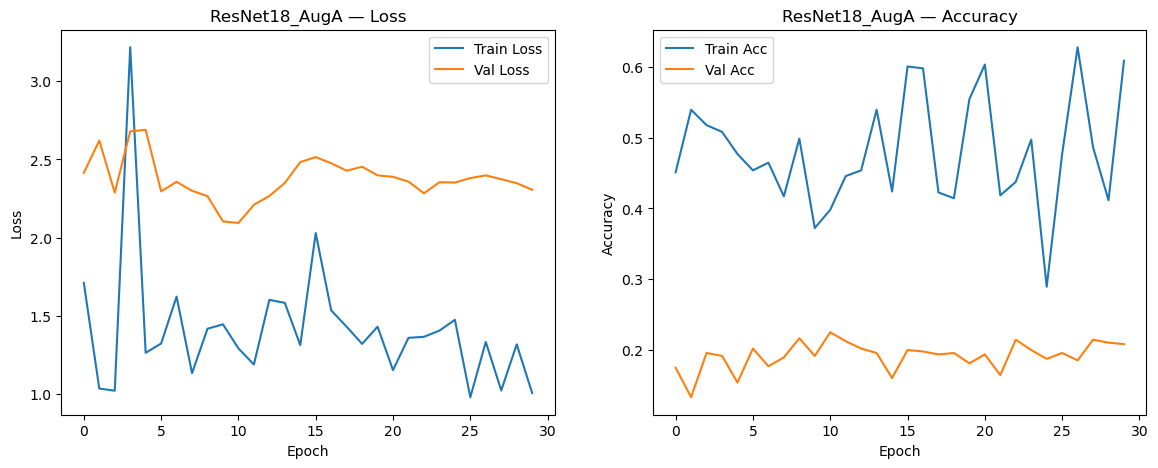

In [27]:
print("\n--- Plotting ResNet18 curves (Aug-A) ---")
plot_history(resnet18_history, "ResNet18_AugA")

In [ ]:
print("\n===== Training EfficientNetB0 (Aug-A) =====\n")

efficientnetA_history = train_model(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    epochs=30,
    lr=1e-4,
    use_mixup=USE_MIXUP
)

print("\n--- Plotting EfficientNetB0 curves (Aug-A) ---")
plot_history(efficientnetA_history, "EfficientNetB0_AugA")

print("\n====== DONE: EfficientNetB0 (Aug-A) ======\n")
